In [7]:
import os
import gc
import cv2
import json
import math
import scipy
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from keras import layers
from keras.applications import ResNet50,MobileNet DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras import layers
from keras.layersiimport Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten,BatchNormalization,GlobalAveragePooling2D
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tqdm import tqdm
from keras import backend as K
from functools import partial
from collections import Counter
from tensorflow.keras import regularizers  #added

%matplotlib inline
np.random.seed(42)  

In [8]:
train_generator = ImageDataGenerator(
        zoom_range=2,  
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
)

BATCH_SIZE = 16

def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/Users/Downloads/BreaKHis 400X/train/benign',224))
malign_train = np.array(Dataset_loader('/Users/Downloads/BreaKHis 400X/train/malignant',224))
benign_test = np.array(Dataset_loader('/Users/Downloads/BreaKHis 400X/test/benign',224))
malign_test = np.array(Dataset_loader('/Users/Downloads/BreaKHis 400X/test/malignant',224))


100%|████████████████████████████████████████| 369/369 [00:02<00:00, 125.79it/s]


100%|████████████████████████████████████████| 371/371 [00:02<00:00, 146.85it/s]


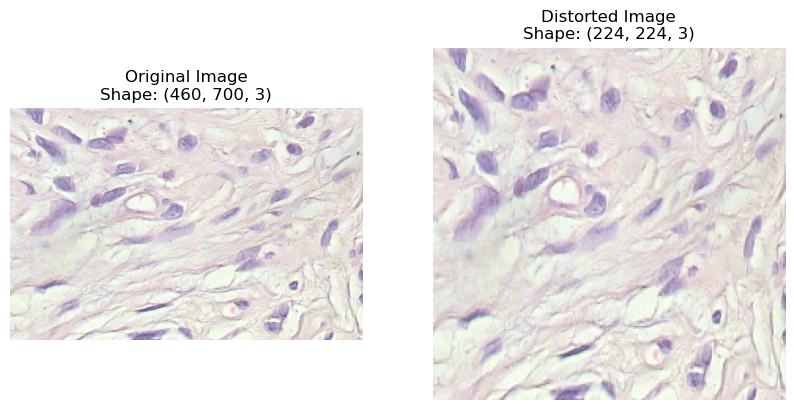

In [9]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm


def Dataset_loader_original(DIR):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            IMG.append(np.array(img))
    return IMG

def plot_images(original_image, distorted_image):
    # Plot the original and distorted images side by side
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title(f'Original Image\nShape: {original_image.shape}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(distorted_image)
    plt.title(f'Distorted Image\nShape: {distorted_image.shape}')
    plt.axis('off')

    plt.show()

benign_train_original = Dataset_loader_original('/Users/Downloads/BreaKHis 400X/train/benign')

benign_train_distorted = Dataset_loader('/Users/Downloads/BreaKHis 400X/train/benign', 224)

plot_images(benign_train_original[0], benign_train_distorted[0])

100%|████████████████████████████████████████| 371/371 [00:02<00:00, 148.04it/s]


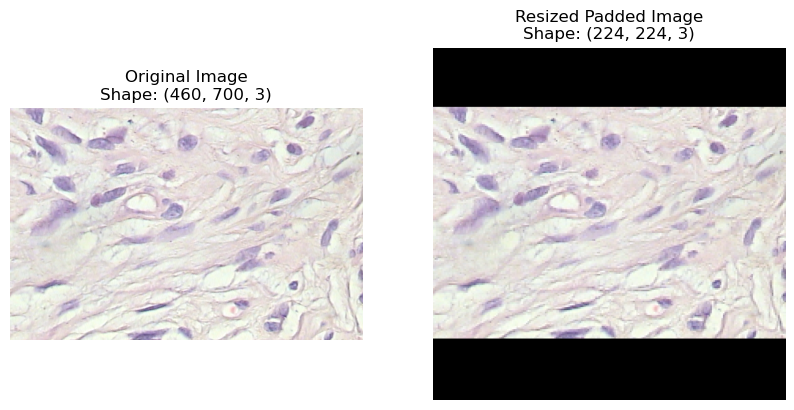

In [10]:
def Dataset_loader_improved(DIR, RESIZE, sigmaX=10):
  file_names = os.listdir(DIR)
  image_paths = [os.path.join(DIR, file_name) for file_name in file_names]
  IMG = [tf.image.resize_with_pad((np.array(Image.open(file).convert("RGB")) / 255.0), RESIZE, RESIZE)
            for file in image_paths]
  return IMG

def plot_images(original_image, resized_image):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title(f'Original Image\nShape: {original_image.shape}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(resized_image)
    plt.title(f'Resized Padded Image\nShape: {resized_image.shape}')
    plt.axis('off')

    plt.show()

benign_train_original = Dataset_loader_original('/Users/Downloads/BreaKHis 400X/train/benign')

benign_train_resized_improved = Dataset_loader_improved('/Users/Downloads/BreaKHis 400X/train/benign', 224)

plot_images(benign_train_original[0], benign_train_resized_improved[0])


In [11]:
import matplotlib.pyplot as plt

def images_plotting(images, title):

    num_images = len(images)

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle(title, fontsize=16)

    for i in range(min(9, num_images)):
        ax = axes[i // 3, i % 3]
        ax.imshow(images[i])
        ax.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

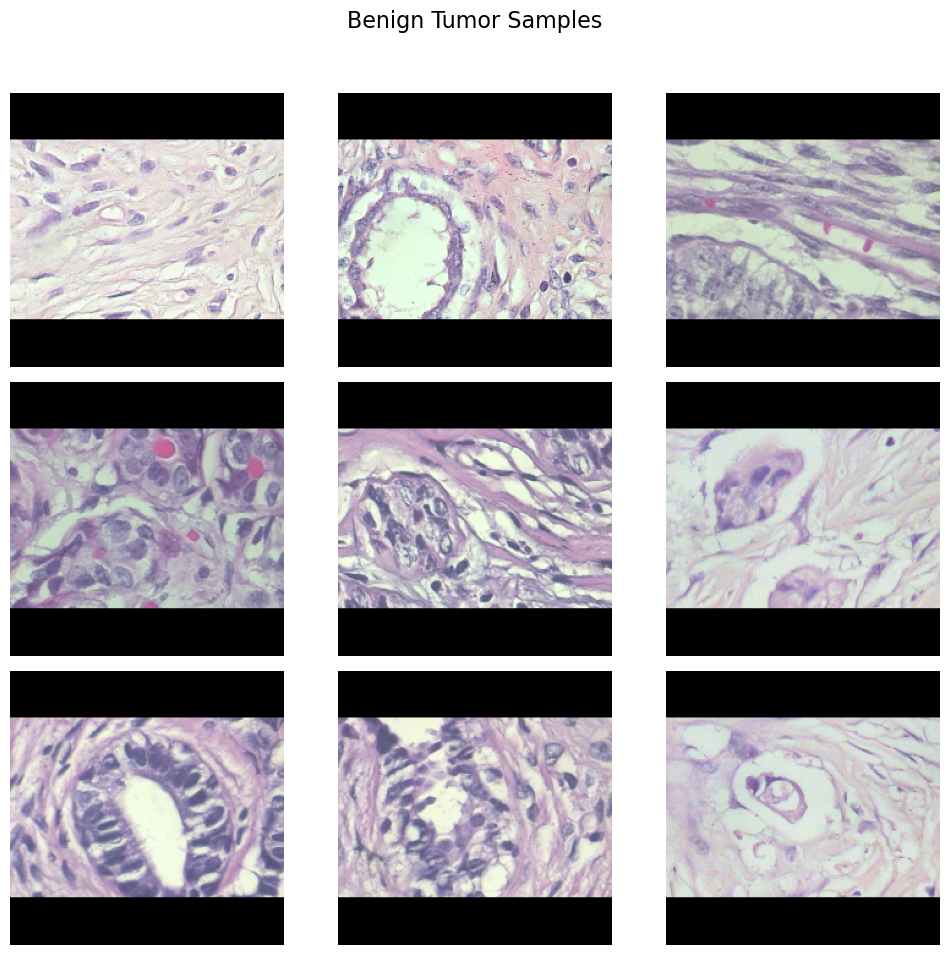

In [12]:
images_plotting(benign_train_resized_improved, "Benign Tumor Samples")

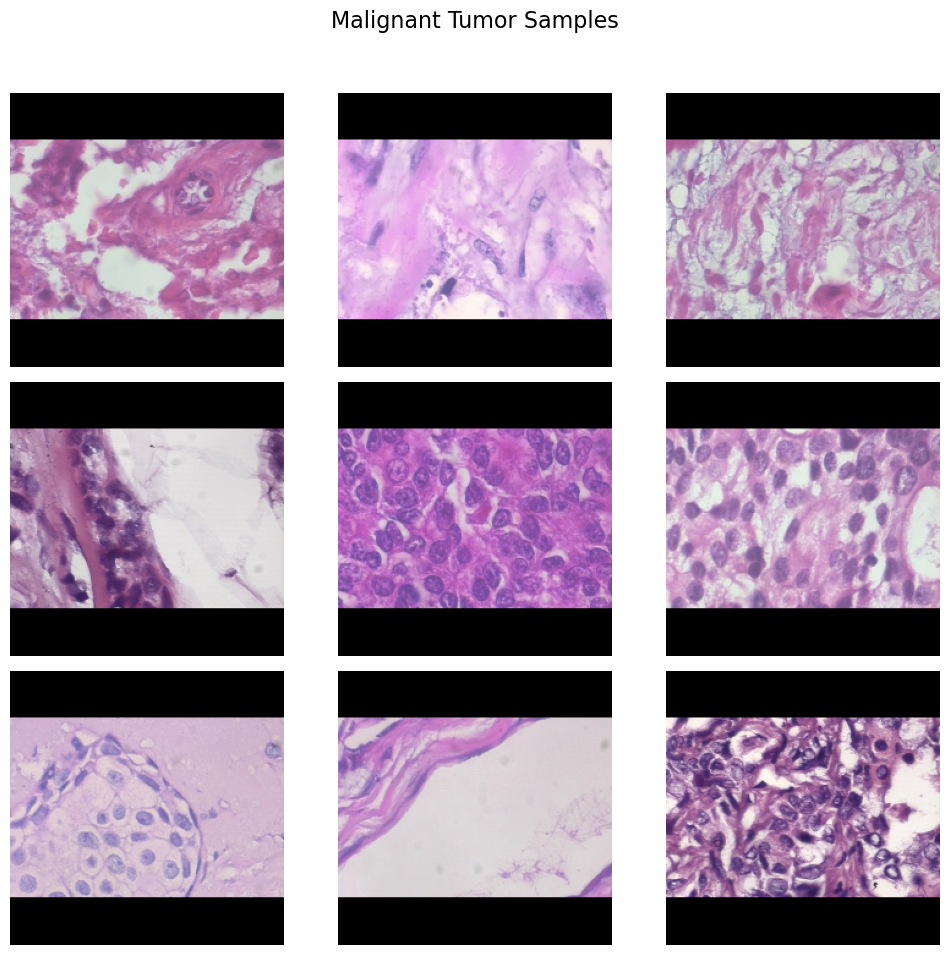

In [13]:
malignant_train_resized_improved = Dataset_loader_improved('/Users/Downloads/BreaKHis 400X/train/malignant', 224)
images_plotting(malignant_train_resized_improved, "Malignant Tumor Samples")

In [14]:
import os
from collections import Counter

# Specify the paths to the directories
directories = [
    '/Users/Downloads/BreaKHis 400X/train/benign',
    '/Users/Downloads/BreaKHis 400X/train/malignant',
    '/Users/Downloads/BreaKHis 400X/test/benign',
    '/Users/Downloads/BreaKHis 400X/test/malignant',
]

# Collect all file names
all_file_names = []

for directory in directories:
    file_names = os.listdir(directory)
    all_file_names.extend(file_names)

# Count the occurrences of each file
file_counts = Counter(all_file_names)

# Find duplicates
duplicates = {file: count for file, count in file_counts.items() if count > 1}

# Print duplicate file names and counts
for file, count in duplicates.items():
    print(f"File: {file}, Duplicates: {count}")
    
if not duplicates:
    print("There are no duplicates!")

There are no duplicates!


In [15]:
import os
from collections import defaultdict

# Function to extract patient_id from filename
def extract_patient_id(filename):
    return filename.split('-')[-3]

# Function to find duplicated patient IDs and their counts
def find_duplicate_patient_ids(train_patient_counts, test_patient_counts):
    duplicates = {
        patient_id: {'Train Count': train_count, 'Test Count': test_count}
        for patient_id, train_count in train_patient_counts.items()
        for test_id, test_count in test_patient_counts.items() if patient_id == test_id
    }
    return duplicates

# Function to count photos for each unique patient_id in a directory
def count_patient_photos(directory):
    patient_counts = defaultdict(int)
    for filename in os.listdir(directory):
        patient_id = extract_patient_id(filename)
        patient_counts[patient_id] += 1
    return patient_counts

# Specify your directories
benign_train_dir = '/Users/Downloads/BreaKHis 400X/train/benign'
malign_train_dir = '/Users/Downloads/BreaKHis 400X/train/malignant'
benign_test_dir = '/Users/Downloads/BreaKHis 400X/test/benign'
malign_test_dir = '/Users/Downloads/BreaKHis 400X/test/malignant'

# Count photos for each unique patient_id in training sets
benign_train_patient_counts = count_patient_photos(benign_train_dir)
malign_train_patient_counts = count_patient_photos(malign_train_dir)

# Count photos for each unique patient_id in test sets
benign_test_patient_counts = count_patient_photos(benign_test_dir)
malign_test_patient_counts = count_patient_photos(malign_test_dir)

# Find and print duplicated patient IDs and their counts
print("Benign - Duplicated Patient IDs:")
duplicated_benign_ids = find_duplicate_patient_ids(benign_train_patient_counts, benign_test_patient_counts)
for patient_id, counts in duplicated_benign_ids.items():
    print(f"Patient ID: {patient_id}, Train Count: {counts['Train Count']}, Test Count: {counts['Test Count']}")

print("\nMalign - Duplicated Patient IDs:")
duplicated_malign_ids = find_duplicate_patient_ids(malign_train_patient_counts, malign_test_patient_counts)
for patient_id, counts in duplicated_malign_ids.items():
    print(f"Patient ID: {patient_id}, Train Count: {counts['Train Count']}, Test Count: {counts['Test Count']}")

Benign - Duplicated Patient IDs:
Patient ID: 23222AB, Train Count: 16, Test Count: 2
Patient ID: 21998AB, Train Count: 35, Test Count: 21
Patient ID: 22549AB, Train Count: 14, Test Count: 11
Patient ID: 9133, Train Count: 15, Test Count: 8
Patient ID: 19854C, Train Count: 12, Test Count: 4
Patient ID: 16184, Train Count: 16, Test Count: 5
Patient ID: 25197, Train Count: 19, Test Count: 14
Patient ID: 21978AB, Train Count: 6, Test Count: 6
Patient ID: 29960CD, Train Count: 11, Test Count: 5
Patient ID: 23060CD, Train Count: 10, Test Count: 4
Patient ID: 29315EF, Train Count: 9, Test Count: 8
Patient ID: 21998EF, Train Count: 15, Test Count: 11
Patient ID: 21998CD, Train Count: 19, Test Count: 12
Patient ID: 29960AB, Train Count: 10, Test Count: 6
Patient ID: 13200, Train Count: 11, Test Count: 3
Patient ID: 14134, Train Count: 23, Test Count: 11
Patient ID: 16184CD, Train Count: 18, Test Count: 10
Patient ID: 15275, Train Count: 14, Test Count: 1
Patient ID: 22704, Train Count: 23, Test

In [16]:
import os
from collections import defaultdict

PATH_TO_BENIGN_TRAIN = benign_train_dir
PATH_TO_BENIGN_TEST = benign_test_dir
PATH_TO_MALIGN_TRAIN = malign_train_dir
PATH_TO_MALIGN_TEST = malign_test_dir

PATH_TO_BENIGN_GAN = '/Users/Downloads/BreaKHis 400X/benign_GAN'

# Count photos for each unique patient_id in benign set
benign_patient_counts = defaultdict(int)

for filename in os.listdir(PATH_TO_BENIGN_TRAIN):
    patient_id = extract_patient_id(filename)
    
    benign_patient_counts[patient_id] += 1
print(benign_patient_counts)
for filename in os.listdir(PATH_TO_BENIGN_TEST):
    patient_id = extract_patient_id(filename)
    benign_patient_counts[patient_id] += 1

# Count photos for each unique patient_id in malign set
malign_patient_counts = defaultdict(int)

for filename in os.listdir(PATH_TO_MALIGN_TRAIN):
    patient_id = extract_patient_id(filename)
    malign_patient_counts[patient_id] += 1

for filename in os.listdir(PATH_TO_MALIGN_TEST):
    patient_id = extract_patient_id(filename)
    malign_patient_counts[patient_id] += 1

# Print the counts for benign set
# print("Benign patient photo counts:")
# for patient_id, count in benign_patient_counts.items():
    # print(f"Patient ID: {patient_id}, Photo Count: {count}")

# Print the counts for malign set
# print("\nMalign set patient photo counts:")
# for patient_id, count in malign_patient_counts.items():
    # print(f"Patient ID: {patient_id}, Photo Count: {count}")


defaultdict(<class 'int'>, {'23222AB': 16, '21998AB': 35, '22549AB': 14, '9133': 15, '19854C': 12, '16184': 16, '25197': 19, '21978AB': 6, '29960CD': 11, '23060CD': 10, '29315EF': 9, '21998EF': 15, '21998CD': 19, '29960AB': 10, '13200': 11, '14134': 23, '16184CD': 18, '15275': 14, '22704': 23, '23060AB': 12, '3411F': 12, '22549G': 23, '22549CD': 18, '14134E': 10})


In [17]:
from sklearn.model_selection import train_test_split

# Function to randomly shuffle patient IDs
def shuffle_patient_ids(patient_counts):
    patient_ids = list(patient_counts.keys())
    shuffled_ids = np.random.permutation(patient_ids)
    return shuffled_ids

# Shuffle patient IDs for benign and malignant cases
shuffled_benign_ids = shuffle_patient_ids(benign_patient_counts)
shuffled_malignant_ids = shuffle_patient_ids(malign_patient_counts)

# Determine the number of patient IDs for training set (e.g., 80%)
train_size_benign = int(0.8 * len(shuffled_benign_ids))
train_size_malignant = int(0.8 * len(shuffled_malignant_ids))

# Split patient IDs into training and test sets
train_benign_ids, test_benign_ids = shuffled_benign_ids[:train_size_benign], shuffled_benign_ids[train_size_benign:]
train_malignant_ids, test_malignant_ids = shuffled_malignant_ids[:train_size_malignant], shuffled_malignant_ids[train_size_malignant:]


# Function to assign images to train/test sets
def assign_images_to_sets(image_counts, train_ids, test_ids):
    train_images = [image for patient_id, count in image_counts.items() if patient_id in train_ids for image in [patient_id] * count]
    test_images = [image for patient_id, count in image_counts.items() if patient_id in test_ids for image in [patient_id] * count]
    return train_images, test_images

# Assign images to train/test sets for benign and malignant cases
train_benign_images, test_benign_images = assign_images_to_sets(benign_patient_counts, train_benign_ids, test_benign_ids)
train_malignant_images, test_malignant_images = assign_images_to_sets(malign_patient_counts, train_malignant_ids, test_malignant_ids)


unique_ids_train_benign_images = set(train_benign_images)
unique_ids_train_benign_images = list(unique_ids_train_benign_images)
unique_ids_test_benign_images = set(test_benign_images)
unique_ids_test_benign_images = list(unique_ids_test_benign_images)


unique_ids_train_malignant_images = set(train_malignant_images)
unique_ids_train_malignant_images = list(unique_ids_train_malignant_images)
unique_ids_test_malignant_images = set(test_malignant_images)
unique_ids_test_malignant_images = list(unique_ids_test_malignant_images)

train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
)

BATCH_SIZE = 16

def Dataset_loader_with_given_ids(DIR_1, DIR_2, RESIZE, IDS):
    file_names_1 = os.listdir(DIR_1)
    image_paths_1 = [os.path.join(DIR_1, file_name) for file_name in file_names_1 if any(id in file_name for id in IDS)]
    IMG_1 = [tf.image.resize_with_pad((np.array(Image.open(file).convert("RGB")) / 255.0), RESIZE, RESIZE)
            for file in image_paths_1]

    file_names_2 = os.listdir(DIR_2)
    image_paths_2 = [os.path.join(DIR_2, file_name) for file_name in file_names_2 if any(id in file_name for id in IDS)]
    IMG_2 = [tf.image.resize_with_pad((np.array(Image.open(file).convert("RGB")) / 255.0), RESIZE, RESIZE)
            for file in image_paths_2]

    return np.array(IMG_1 + IMG_2), np.array(image_paths_1 + image_paths_2)

benign_train, benign_train_file_paths = Dataset_loader_with_given_ids("/Users/Downloads/BreaKHis 400X/train/benign", "/Users/Downloads/BreaKHis 400X/test/benign", 224, unique_ids_train_benign_images)
malign_train, malign_train_file_paths = Dataset_loader_with_given_ids("/Users/Downloads/BreaKHis 400X/train/malignant", "/Users/Downloads/BreaKHis 400X/test/malignant", 224, unique_ids_train_malignant_images)
benign_test, benign_test_file_paths = Dataset_loader_with_given_ids("/Users/Downloads/BreaKHis 400X/train/benign", "/Users/Downloads/BreaKHis 400X/test/benign", 224, unique_ids_test_benign_images)
malign_test, malign_test_file_paths = Dataset_loader_with_given_ids("/Users/Downloads/BreaKHis 400X/train/malignant", "/Users/Downloads/BreaKHis 400X/test/malignant", 224, unique_ids_test_malignant_images)

benign_train.shape

(455, 224, 224, 3)

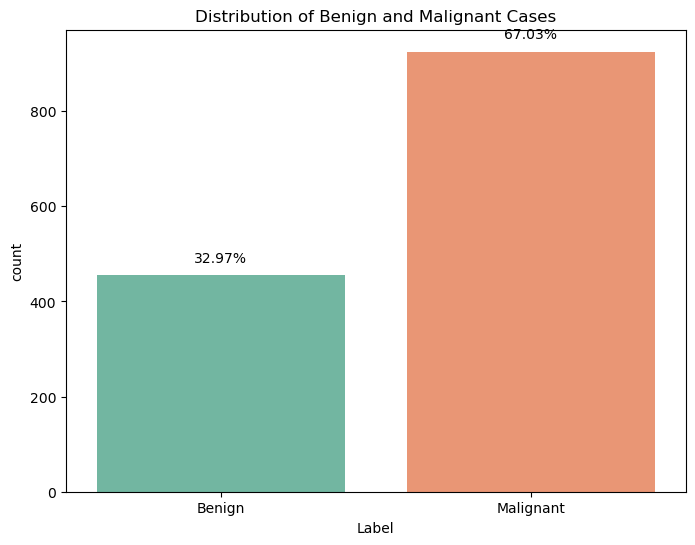

In [18]:
# Code that you can add to the original

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame for visualization
data = {"Label": ["Benign"] * len(benign_train) + ["Malignant"] * len(malign_train)}
df = pd.DataFrame(data)

# Calculate percentages
percentage_counts = df["Label"].value_counts(normalize=True) * 100

# Plot the distribution with percentages
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="Label", data=df, palette="Set2")
plt.title("Distribution of Benign and Malignant Cases")

# Display percentages on the y-axis
total = len(df)
for p in ax.patches:
    percentage = f"{p.get_height() / total * 100:.2f}%"
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 0.02 * total  # Adjust the vertical position
    ax.annotate(percentage, (x, y), ha="center")

plt.show()

In [19]:
'''
# Oversampling the benign train dataset

!git clone https://github.com/sophiajw/HistAuGAN.git
%cd HistAuGAN

# load model weights from https://drive.google.com/file/d/1uObebkPgx_q6cZznGaUps-RfoSrUhNnD/view?usp=sharing
!gdown https://drive.google.com/uc?id=1uObebkPgx_q6cZznGaUps-RfoSrUhNnD

### Before executing the next cell, the file histaugen/model.py has to be modified. The line import networks needs to be changed with import histaugan.networks as networks.

%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from PIL import Image

from augmentations import generate_hist_augs, opts, mean_domains, std_domains
from histaugan.model import MD_multi

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = MD_multi(opts)
model.resume(opts.resume, train=False)
model.to(device)
model.eval();
print('--- model loaded ---')

# Final code for generating the augmented images

from PIL import Image
import os
import random
import matplotlib.pyplot as plt


number_of_generated_images = 0
# Iterate over all files in the folder
for image_path in benign_train_file_paths:
    # Ensure that the file is an image (you may need to customize this check)
    if image_path.lower().endswith(('.png')):
        # Open the image
        image = Image.open(image_path).convert("RGB")

        # Define the desired size
        desired_size = (460, 700)

        # Resize the image to the desired size
        image = transforms.functional.resize(image, desired_size)

        rows, columns, img_size = 1, 6, 3

        z_content = model.enc_c(transform(image).sub(0.5).mul(2).unsqueeze(0))

        # Generate two different random numbers between 0 and 4
        random_number1 = random.randint(0, 4)
        random_number2 = random.randint(0, 4)

        # Make sure random_number1 is different from random_number2
        while random_number1 == random_number2:
          random_number2 = random.randint(0, 4)

        for i in range(rows * columns - 1):
          out = generate_hist_augs(transform(image), domain, model, z_content, new_domain=i, stats=(mean_domains, std_domains), device=device)
          if random_number1 == i or random_number2 == i:
            # Save the chosen augmented image as a PNG
            augmented_image = out.add(1).div(2).permute(1, 2, 0).cpu().numpy()

            augmented_image_name = 'generated_image_' + str(number_of_generated_images)

            save_path = PATH_TO_BENIGN_GAN + augmented_image_name + '.png'
            plt.imsave(save_path, augmented_image)

            number_of_generated_images = number_of_generated_images + 1

        # Close the image to free resources
        image.close()

print("It is necessary to add at most " + str(int(malign_train.shape[0]) - int(benign_train.shape[0])) + " images to the benign_train set so that the final train dataset is class balanced.")

'''

'\n# Oversampling the benign train dataset\n\n!git clone https://github.com/sophiajw/HistAuGAN.git\n%cd HistAuGAN\n\n# load model weights from https://drive.google.com/file/d/1uObebkPgx_q6cZznGaUps-RfoSrUhNnD/view?usp=sharing\n!gdown https://drive.google.com/uc?id=1uObebkPgx_q6cZznGaUps-RfoSrUhNnD\n\n### Before executing the next cell, the file histaugen/model.py has to be modified. The line import networks needs to be changed with import histaugan.networks as networks.\n\n%load_ext autoreload\n%autoreload 2\n\nimport torch\nimport numpy as np\nimport os\nimport matplotlib.pyplot as plt\nimport matplotlib.gridspec as gridspec\n\nfrom PIL import Image\n\nfrom augmentations import generate_hist_augs, opts, mean_domains, std_domains\nfrom histaugan.model import MD_multi\n\ndevice = torch.device(\'cuda\') if torch.cuda.is_available() else torch.device(\'cpu\')\n\nmodel = MD_multi(opts)\nmodel.resume(opts.resume, train=False)\nmodel.to(device)\nmodel.eval();\nprint(\'--- model loaded ---\')

In [21]:

def Dataset_loader_oversampled_images(DIR, RESIZE, sigmaX=10, num_examples=450):
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    file_names = os.listdir(DIR)
    even_file_names = [file_name for file_name in file_names if int(file_name.split('_')[-1].split('.')[0]) % 2 == 0]
    odd_file_names = [file_name for file_name in file_names if int(file_name.split('_')[-1].split('.')[0]) % 2 != 0]

    selected_file_names = even_file_names[:num_examples]

    remaining = num_examples - len(selected_file_names)
    if remaining > 0:
        selected_file_names.extend(odd_file_names[:remaining])

    image_paths = [os.path.join(DIR, file_name) for file_name in selected_file_names]
    # print(image_paths)
    IMG = [tf.image.resize_with_pad((np.array(Image.open(file).convert("RGB")) / 255.0), RESIZE, RESIZE)
            for file in image_paths]

    return IMG

benign_train_oversampled = np.array(Dataset_loader_oversampled_images(PATH_TO_BENIGN_GAN, 224))

print(benign_train_oversampled.shape)

benign_train_minority = benign_train.copy()

print(benign_train.shape)

benign_train = np.concatenate([benign_train_minority, benign_train_oversampled], axis=0)

del benign_train_minority
del benign_train_oversampled

print(benign_train.shape)

(450, 224, 224, 3)
(455, 224, 224, 3)
(905, 224, 224, 3)


In [23]:
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))
label =  {0:"benign",1:"malignant"}

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

In [24]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [25]:
# Edit previous cell code

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.seed(11) 
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.seed(11) 
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [26]:
# Code that you can add to the original

import seaborn as sns

if Y_train.dtype != np.int64:
    Y_train = Y_train.astype(int)

counts = np.bincount(Y_train)
percentages = counts / counts.sum() * 100

df = pd.DataFrame({
    "Label": [label[i] for i in range(len(counts))],
    "Count": counts,
    "Percentage [%]": percentages
})
print(df)

       Label  Count  Percentage [%]
0     benign    905       49.453552
1  malignant    925       50.546448


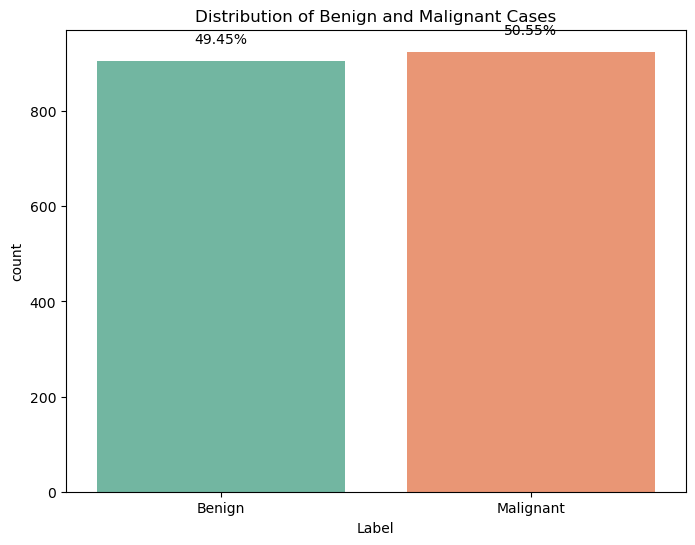

In [27]:
# Code that you can add to the original

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame for visualization
data = {"Label": ["Benign"] * len(benign_train) + ["Malignant"] * len(malign_train)}
df = pd.DataFrame(data)

# Calculate percentages
percentage_counts = df["Label"].value_counts(normalize=True) * 100

# Plot the distribution with percentages
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="Label", data=df, palette="Set2")
plt.title("Distribution of Benign and Malignant Cases")

# Display percentages on the y-axis
total = len(df)
for p in ax.patches:
    percentage = f"{p.get_height() / total * 100:.2f}%"
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 0.02 * total  # Adjust the vertical position
    ax.annotate(percentage, (x, y), ha="center")

plt.show()

In [28]:
# Train and Validation split 
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state= 11
)


In [29]:
# Edit previous cell code

x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2, 
    stratify = Y_train,
    random_state= 11)

In [30]:
# Code that you can add to the original

table = pd.DataFrame({"B": [np.bincount(y_train)[0],np.bincount(y_val)[0]],
                      "M": [np.bincount(y_train)[1],np.bincount(y_val)[1]]}, 
                      index=["Train", "Validation"])
                     

table[" "]     = table.sum(axis=1)
table.loc[" "] = table.sum(axis=0)

table = table*100/table.loc[" "," "]
table = table.round(2)
print("Class distribution (%) in train/validation using stratify split:")
table

Class distribution (%) in train/validation using stratify split:


B      M       
Train       39.56  40.44   80.0
Validation   9.89  10.11   20.0
            49.45  50.55  100.0

In [31]:
# To categorical
y_train = to_categorical(y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [32]:
y_val=to_categorical(y_val, num_classes= 2)

In [33]:
print(f"Shape y_train= {y_train.shape}")
print(f"Shape x_train= {x_train.shape}")
print(f"Shape x_val= {x_val.shape}")
print(f"Shape y_val= {y_val.shape}")
print(f"Shape X_test= {X_test.shape}")
print(f"Shape Y_test= {Y_test.shape}")

Shape y_train= (1464, 2)
Shape x_train= (1464, 224, 224, 3)
Shape x_val= (366, 224, 224, 3)
Shape y_val= (366, 2)
Shape X_test= (331, 224, 224, 3)
Shape Y_test= (331, 2)


In [34]:
#build cnn
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

74836368/74836368 [==============================] - 20s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 16)          276496    
                                                                 
 max_pooling2d (MaxPooling2  (None, 5, 5, 16)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 64)          1

In [35]:
# Edit previous cell code
#build cnn
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax',kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
    )
    
    return model

K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 16)          276496    
                                                                 
 max_pooling2d (MaxPooling2  (None, 5, 5, 16)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 64)          1

In [36]:
#early stop  to avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [37]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs= 9,
    validation_data=(x_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/9
91/91 [==============================] - 251s 3s/step - loss: 0.6740 - accuracy: 0.6598 - precision: 0.6598 - recall: 0.6598 - auc: 0.7236 - val_loss: 8.4534 - val_accuracy: 0.5055 - val_precision: 0.5055 - val_recall: 0.5055 - val_auc: 0.5055
Epoch 2/9
91/91 [==============================] - 245s 3s/step - loss: 0.5106 - accuracy: 0.7766 - precision: 0.7766 - recall: 0.7766 - auc: 0.8582 - val_loss: 1.1350 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.6955
Epoch 3/9
91/91 [==============================] - 228s 2s/step - loss: 0.4613 - accuracy: 0.8183 - precision: 0.8183 - recall: 0.8183 - auc: 0.8826 - val_loss: 0.9339 - val_accuracy: 0.8197 - val_precision: 0.8197 - val_recall: 0.8197 - val_auc: 0.8480
Epoch 4/9
91/91 [==============================] - 224s 2s/step - loss: 0.4894 - accuracy: 0.7992 - precision: 0.7992 - recall: 0.7992 - auc: 0.8630 - val_loss: 0.6311 - val_accuracy: 0.8361 - val_precision: 0.8361 - val_recall: 0.8361 - 

In [38]:
#evaluate model
model.evaluate(x_val, y_val)

12/12 [==============================] - 10s 820ms/step - loss: 0.3547 - accuracy: 0.8825 - precision: 0.8825 - recall: 0.8825 - auc: 0.9230


[0.3547494113445282,
 0.8825136423110962,
 0.8825136423110962,
 0.8825136423110962,
 0.9229747653007507]

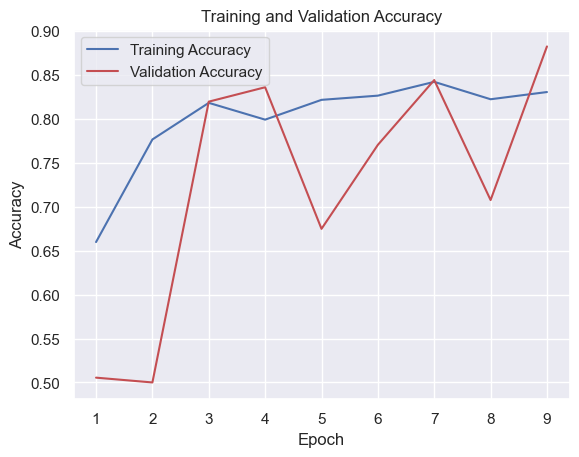

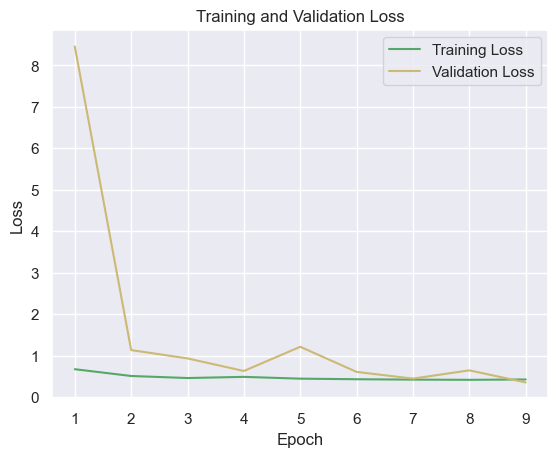

In [39]:
#plotting training values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, accuracy, color='b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, color='r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='g', label='Training Loss')
plt.plot(epochs, val_loss, color='y', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [40]:
Y_pred = model.predict(X_test)
# Y_pred = np.argmax(Y_pred,axis=1)
# Y_pred

11/11 [==============================] - 10s 786ms/step


In [41]:
# Code that you can add to the original
loss, accuracy, precision, recall, auc= model.evaluate(X_test, Y_test)

11/11 [==============================] - 9s 783ms/step - loss: 0.6545 - accuracy: 0.8036 - precision: 0.8036 - recall: 0.8036 - auc: 0.8166


In [42]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)
# Y_pred_tta = np.argmax(Y_pred_tta,axis=1)
# Y_pred_tta

  0%|                                                    | 0/10 [00:00<?, ?it/s]

20/20 [==============================] - 11s 500ms/step


 10%|████▍                                       | 1/10 [00:11<01:46, 11.85s/it]

20/20 [==============================] - 11s 511ms/step


 20%|████████▊                                   | 2/10 [00:22<01:31, 11.38s/it]

20/20 [==============================] - 11s 505ms/step


 30%|█████████████▏                              | 3/10 [00:33<01:18, 11.16s/it]

20/20 [==============================] - 10s 501ms/step


 40%|█████████████████▌                          | 4/10 [00:44<01:06, 11.04s/it]

20/20 [==============================] - 10s 500ms/step


 50%|██████████████████████                      | 5/10 [00:55<00:54, 10.96s/it]

20/20 [==============================] - 11s 513ms/step


 60%|██████████████████████████▍                 | 6/10 [01:06<00:43, 11.00s/it]

20/20 [==============================] - 10s 503ms/step


 70%|██████████████████████████████▊             | 7/10 [01:17<00:32, 10.96s/it]

20/20 [==============================] - 11s 508ms/step


 80%|███████████████████████████████████▏        | 8/10 [01:28<00:21, 10.96s/it]

20/20 [==============================] - 11s 518ms/step


 90%|███████████████████████████████████████▌    | 9/10 [01:39<00:11, 11.03s/it]

20/20 [==============================] - 11s 521ms/step


100%|███████████████████████████████████████████| 10/10 [01:50<00:00, 11.08s/it]


In [43]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap='OrRd')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 50  42]
 [ 23 216]]


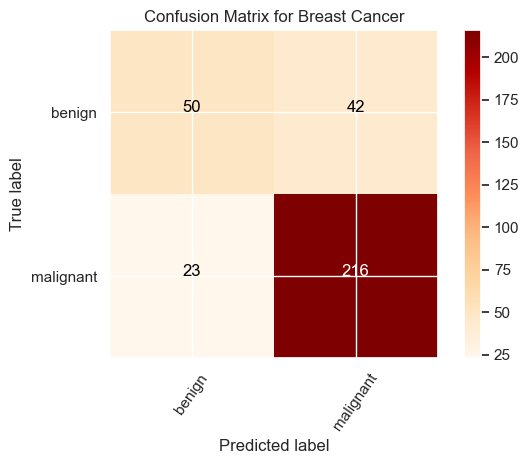

In [44]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred,axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Matrix for Breast Cancer')

Confusion matrix, without normalization
[[ 45  47]
 [ 20 219]]


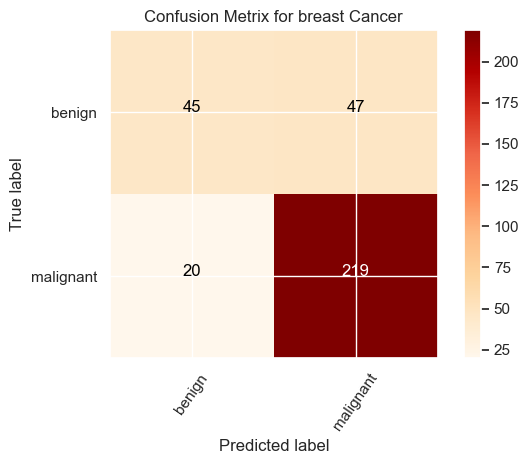

In [45]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta,axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for breast Cancer')

In [46]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred,axis=1)))

              precision    recall  f1-score   support

           0       0.68      0.54      0.61        92
           1       0.84      0.90      0.87       239

    accuracy                           0.80       331
   macro avg       0.76      0.72      0.74       331
weighted avg       0.79      0.80      0.80       331



In [47]:
from sklearn.metrics import classification_report

print(classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta,axis=1)))

              precision    recall  f1-score   support

           0       0.69      0.49      0.57        92
           1       0.82      0.92      0.87       239

    accuracy                           0.80       331
   macro avg       0.76      0.70      0.72       331
weighted avg       0.79      0.80      0.79       331



In [48]:
from sklearn.metrics import cohen_kappa_score, balanced_accuracy_score

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred,axis=1))
print("Cohen's Kappa:", kappa)

# Calculate Balanced Accuracy
balanced_acc = balanced_accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred,axis=1))
print("Balanced Accuracy:", balanced_acc)

Cohen's Kappa: 0.4775756987106331
Balanced Accuracy: 0.7236219756230671


In [49]:
from sklearn.metrics import cohen_kappa_score, balanced_accuracy_score

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta,axis=1))
print("Cohen's Kappa:", kappa)

# Calculate Balanced Accuracy
balanced_acc = balanced_accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta,axis=1))
print("Balanced Accuracy:", balanced_acc)

Cohen's Kappa: 0.44567200739870516
Balanced Accuracy: 0.7027242132072039


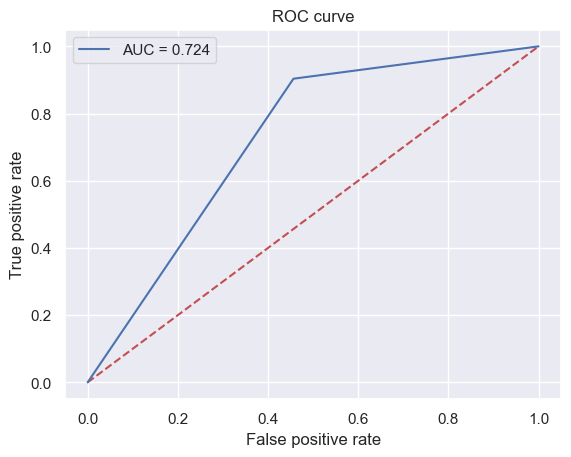

In [50]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

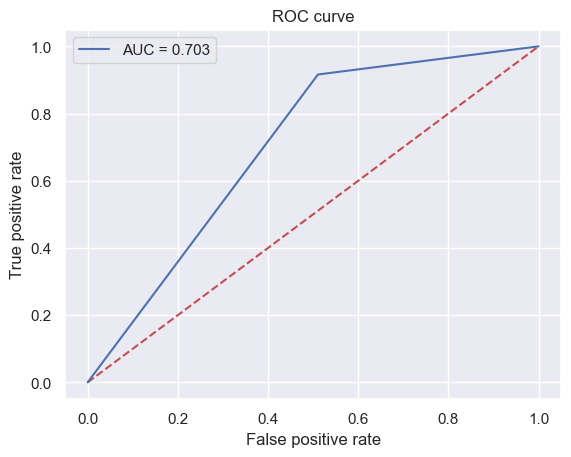

In [51]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

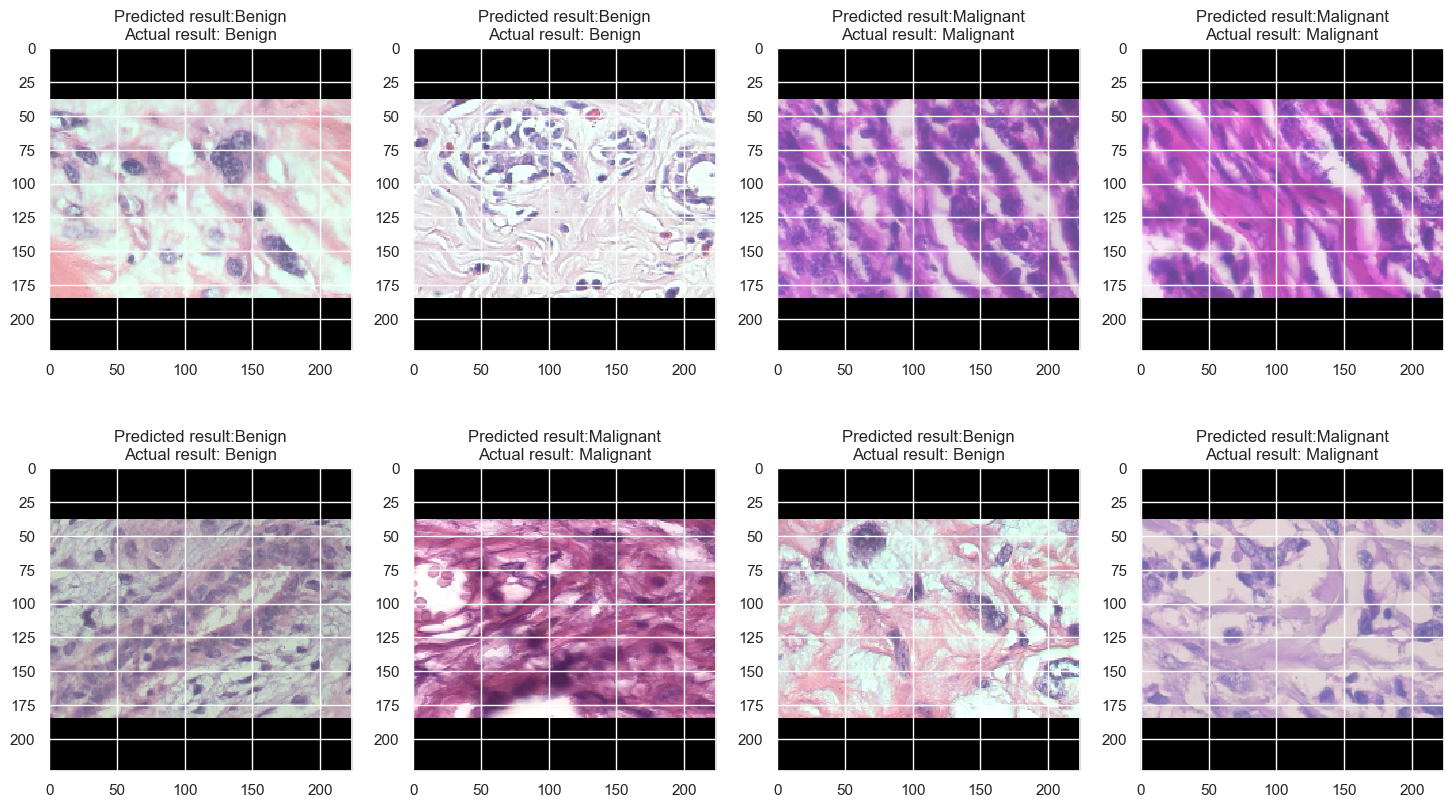

In [52]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 random images
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

1/1 [==============================] - 0s 114ms/step
[0]
benign


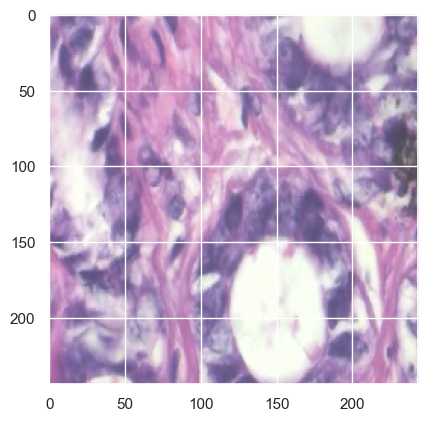

In [54]:
#test model 1
img_ = image.load_img("/Users/Downloads/BreaKHis 400X/test/benign/SOB_B_TA-14-16184-400-019.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

1/1 [==============================] - 0s 103ms/step
[0]
benign


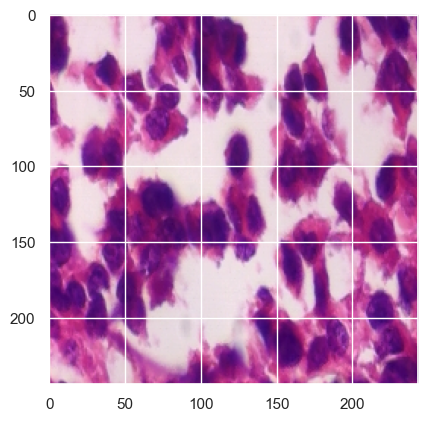

In [57]:
#test model 2
img_ = image.load_img("/Users/Downloads/BreaKHis 400X/test/malignant/SOB_M_DC-14-2773-400-004.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

1/1 [==============================] - 0s 106ms/step
[0]
benign


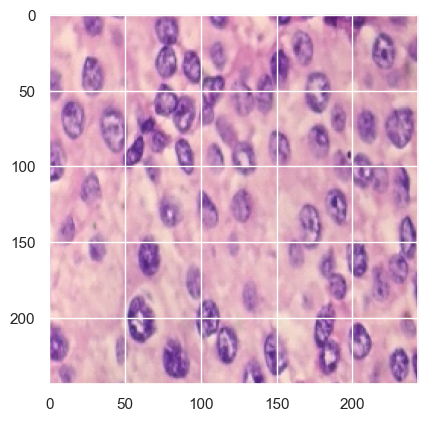

In [58]:
#test model 3
img_ = image.load_img("/Users/Downloads/BreaKHis 400X/test/malignant/SOB_M_DC-14-11031-400-003.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

1/1 [==============================] - 0s 113ms/step
[0]
benign


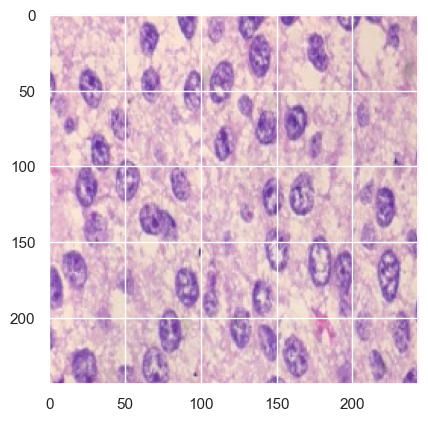

In [59]:
#test model 4
img_ = image.load_img("/Users/Downloads/BreaKHis 400X/train/malignant/SOB_M_DC-14-11031-400-007.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

1/1 [==============================] - 0s 102ms/step
[0]
benign


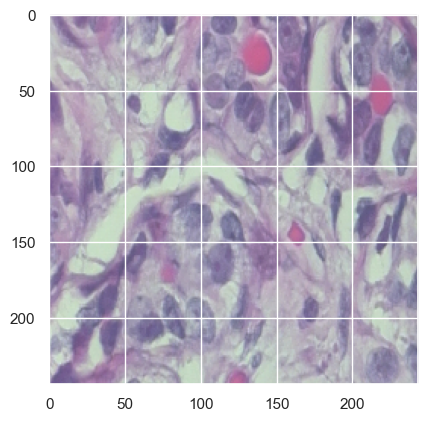

In [60]:
#test model 5
img_ = image.load_img("/Users/Downloads/BreaKHis 400X/train/benign/SOB_B_A-14-22549AB-400-022.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

1/1 [==============================] - 0s 107ms/step
[1]
malignant


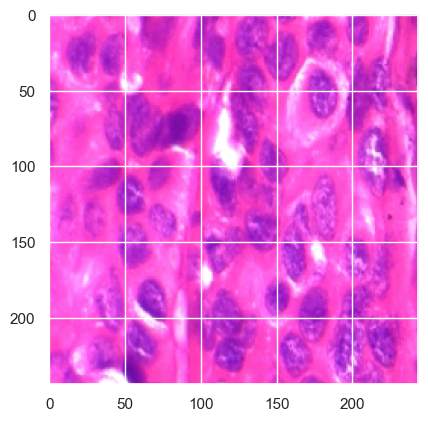

In [61]:
#test model 6
img_ = image.load_img("/Users/Downloads/BreaKHis 400X/train/malignant/SOB_M_DC-14-9461-400-006.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

1/1 [==============================] - 0s 109ms/step
[0]
benign


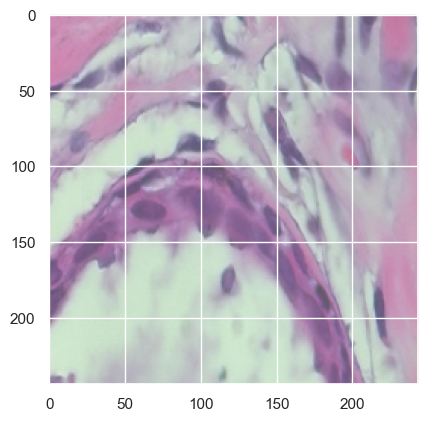

In [62]:
#test model 7
img_ = image.load_img("/Users/Downloads/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-003.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)


1/1 [==============================] - 0s 106ms/step
[0]
benign


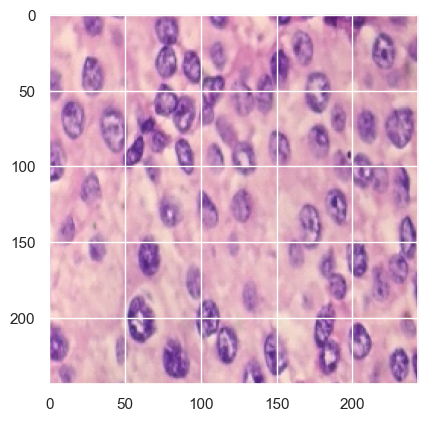

In [63]:
#test model 8
img_ = image.load_img("/Users/Downloads/BreaKHis 400X/test/malignant/SOB_M_DC-14-11031-400-003.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)